In [1]:
# -------------------------------
# Tugas 1: Bangun VAE untuk Fashion-MNIST
# -------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Konversi ke float32 dan normalisasi ke [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan padding menjadi 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Tambahkan channel grayscale (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Data shape:", x_train.shape, x_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data shape: (60000, 32, 32, 1) (10000, 32, 32, 1)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# -------------------------------
# 2. Bangun Encoder
# -------------------------------
latent_dim = 2

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = x.shape[1:]  # simpan shape untuk decoder
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# -------------------------------
# 3. Bangun Decoder
# -------------------------------
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# -------------------------------
# 4. Bangun VAE dengan Custom Training Loop
# -------------------------------
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())

In [7]:
# -------------------------------
# 5. Latih Model
# -------------------------------
# Re-compile VAE with a dummy loss as the original compile was missing it
# Correcting the loss argument to match the multiple outputs of VAE.call() for validation.
vae.compile(optimizer=optimizers.Adam(), loss=[None, None, tf.keras.losses.MeanSquaredError()])
history = vae.fit(x_train, epochs=15, batch_size=128, validation_data=(x_test, x_test))



Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 198s 413ms/step - kl_loss: 6.4991 - reconstruction_loss: 253.7292 - total_loss: 260.2282 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 198s 406ms/step - kl_loss: 6.5672 - reconstruction_loss: 252.1081 - total_loss: 258.6753 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 207s 416ms/step - kl_loss: 6.5759 - reconstruction_loss: 252.0495 - total_loss: 258.6255 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 400ms/step - kl_loss: 6.5846 - reconstruction_loss: 252.2357 - total_loss: 258.8203 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 184s 392ms/step - kl_loss: 6.6149 - reconstruction_loss: 251.1380 - tota

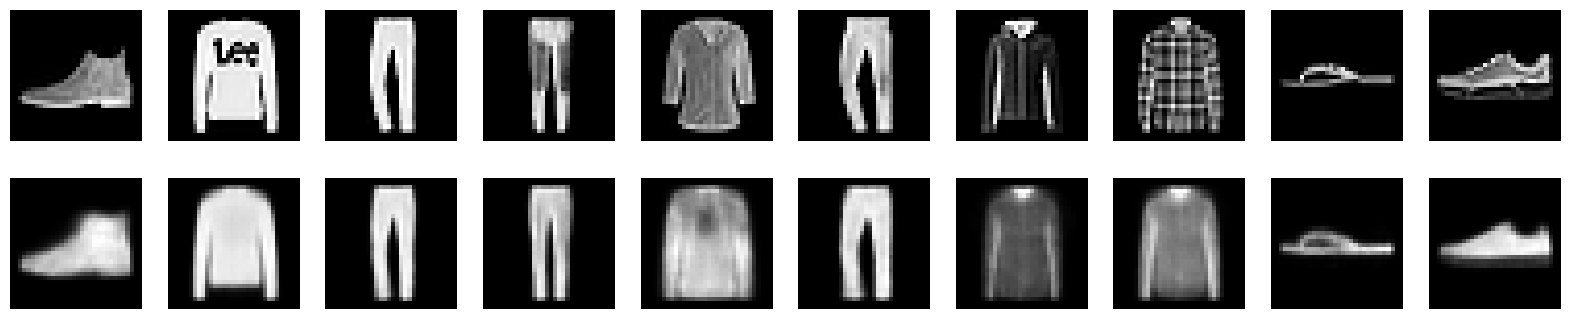

In [8]:
# -------------------------------
# 6. Visualisasi Rekonstruksi
# -------------------------------
def plot_reconstructions(model, data, n=10):
    _, _, reconstructions = model(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap="gray") # Fixed line
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

# -------------------------------
# 7. Simpan Model (opsional)
# -------------------------------
encoder.save("vae_fashion_encoder.h5")
decoder.save("vae_fashion_decoder.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


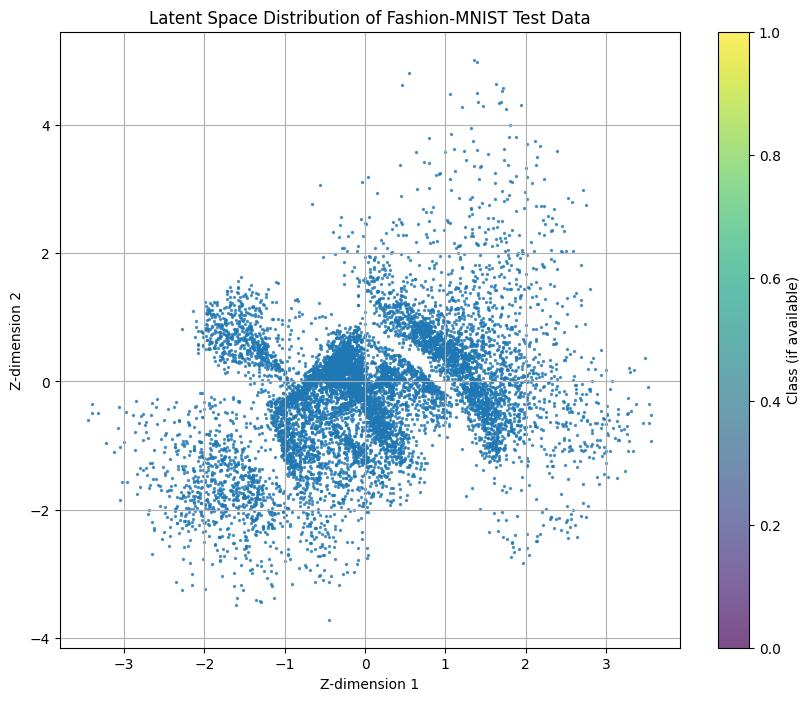

In [9]:
import matplotlib.pyplot as plt

# Asumsi z_means sudah dihitung dan tersedia dari encoder(x_test)
# Jika belum, uncomment baris berikut:
z_means, _, _ = vae.encoder.predict(x_test)

plt.figure(figsize=(10, 8))
plt.scatter(z_means[:, 0], z_means[:, 1], alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data")
plt.colorbar(label="Class (if available)") # Label ini akan tetap muncul, namun tidak ada warna berdasarkan kelas karena tidak ada label kelas yang dimuat.
plt.grid(True)
plt.show()

In [10]:
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()
print("y_test successfully loaded with shape:", y_test.shape)
print("First 10 y_test labels:", y_test[:10])

y_test successfully loaded with shape: (10000,)
First 10 y_test labels: [9 2 1 1 6 1 4 6 5 7]


## Generate Latent Space Means for Test Data



In [11]:
print("Shape of z_means:", z_means.shape)
print("First 5 elements of z_means:\n", z_means[:5])

Shape of z_means: (10000, 2)
First 5 elements of z_means:
 [[ 1.3457283   0.5571531 ]
 [-0.2834532   0.2843928 ]
 [-2.6501534  -1.2766076 ]
 [-1.4935691  -1.8207484 ]
 [ 0.11033009 -0.1696584 ]]


## Visualize Latent Space Distribution by Class



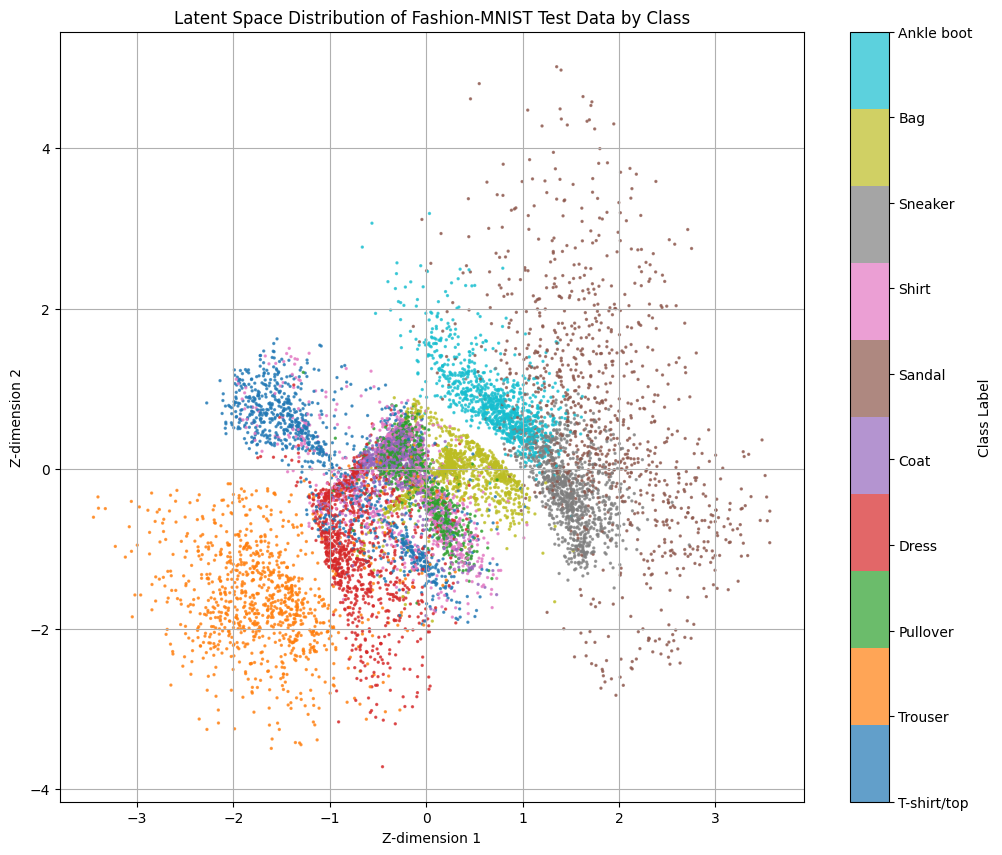

In [12]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_means[:, 0], z_means[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data by Class")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


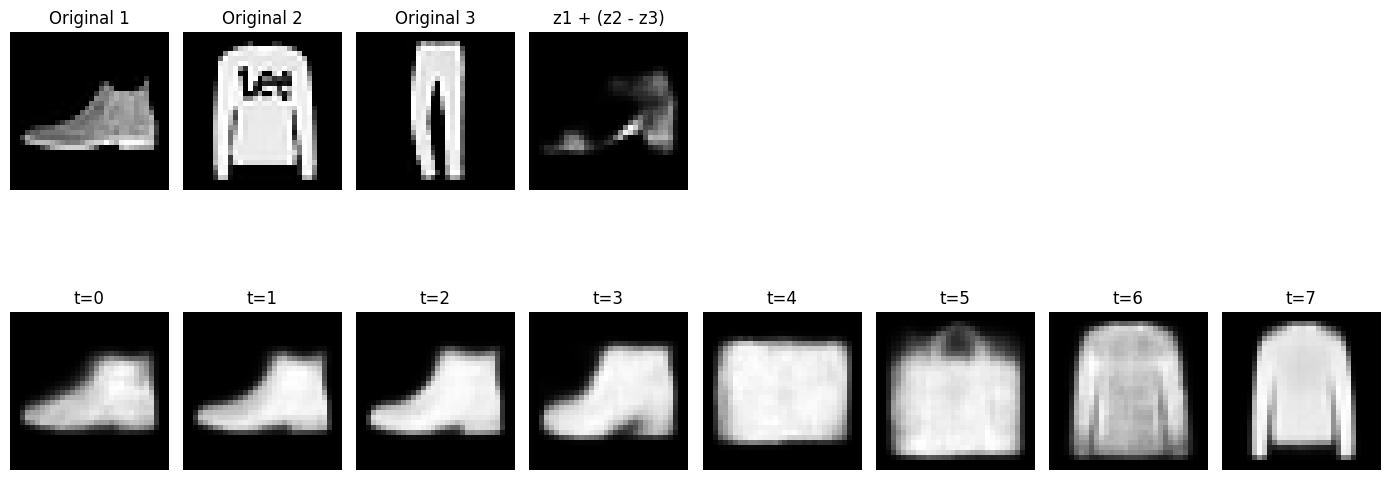

In [13]:
# ===== TUGAS 3 LATENT SPACE ARITHMETIC =====
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mendapatkan z_mean dari encoder
def get_z_mean(encoder, x):
    out = encoder.predict(x)
    # output encoder biasanya [z_mean, z_log_var, z]
    if isinstance(out, list) or isinstance(out, tuple):
        return out[0]       # z_mean
    return out             # kalau hanya 1 output

# Pilih 3 sampel dari x_test
idxs = [0, 1, 2]
samples = x_test[idxs]

# Encode ke latent space
z_means = get_z_mean(encoder, samples)

z1, z2, z3 = z_means[0], z_means[1], z_means[2]

# Rumus latent arithmetic
z_new = z1 + (z2 - z3)

# Decode hasil arithmetic
x_new = decoder.predict(np.expand_dims(z_new, 0))[0]

# ---- INTERPOLASI antara z1 → z2 ----
def interpolate(z1, z2, steps=8):
    return np.array([z1 + (z2 - z1) * (i / (steps - 1)) for i in range(steps)])

interp_z = interpolate(z1, z2, 8)
interp_imgs = decoder.predict(interp_z)

# ---- Plot hasil ----
plt.figure(figsize=(14,6))

# 3 original images
for i in range(3):
    plt.subplot(2, 8, i+1)
    plt.imshow(samples[i].squeeze(), cmap="gray")
    plt.title(f"Original {i+1}")
    plt.axis("off")

# arithmetic result
plt.subplot(2, 8, 4)
plt.imshow(x_new.squeeze(), cmap="gray")
plt.title("z1 + (z2 - z3)")
plt.axis("off")

# interpolation row
for i in range(8):
    plt.subplot(2, 8, 8 + i + 1)
    plt.imshow(interp_imgs[i].squeeze(), cmap="gray")
    plt.title(f"t={i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Autoencoder on MNIST...
Autoencoder training complete.
Loading Fashion-MNIST data for VAE reconstruction...
Fashion-MNIST test data shape for VAE: (10000, 32, 32, 1)
Performing VAE reconstruction (Fashion-MNIST)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
VAE reconstruction complete.
Performing Autoencoder reconstruction (MNIST)...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Autoencoder reconstruction complete.


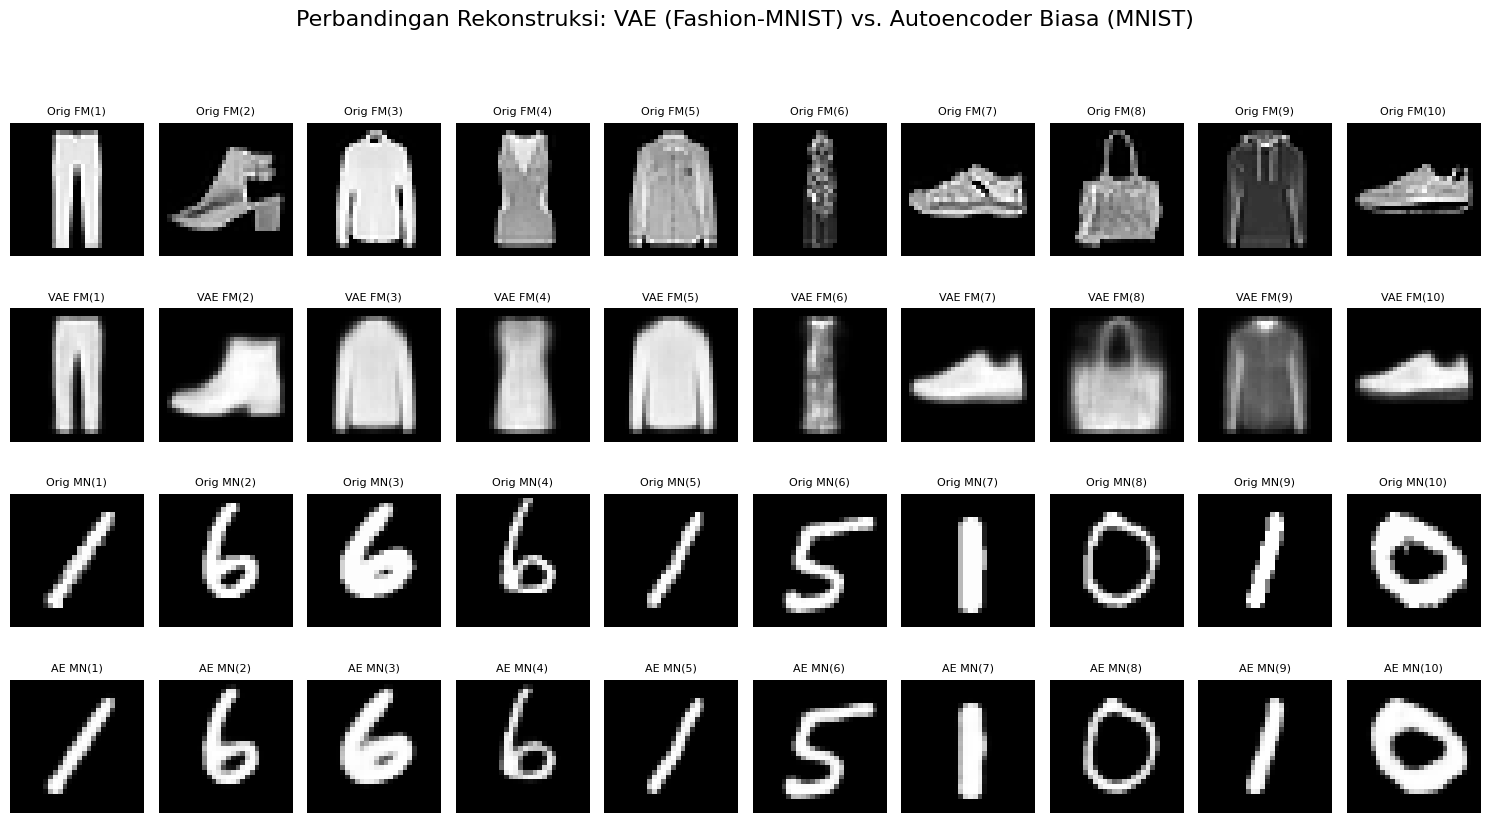

In [14]:
# =====================================================
# TUGAS 4 — Perbandingan Rekonstruksi VAE dan AE Biasa
# =====================================================

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np # Make sure numpy is imported

# ----------- LOAD MNIST DATA for Autoencoder -----------
# Load MNIST for the Autoencoder
(x_train_mnist, _), (x_test_mnist, _) = tf.keras.datasets.mnist.load_data()
x_train_mnist = x_train_mnist.astype("float32") / 255.
x_test_mnist = x_test_mnist.astype("float32") / 255.
x_train_mnist = x_train_mnist.reshape(-1, 28, 28, 1)
x_test_mnist = x_test_mnist.reshape(-1, 28, 28, 1)

# ----------- Autoencoder Biasa -----------
input_shape_ae = x_train_mnist.shape[1:]

ae_input = layers.Input(shape=input_shape_ae)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(ae_input)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D(2, padding="same")(x)

x = layers.Conv2D(16, 3, activation="relu", padding="same")(encoded)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
decoded = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

autoencoder = models.Model(ae_input, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# ----------- Training Autoencoder (epoch = 15) -----------
print("Training Autoencoder on MNIST...")
history_ae = autoencoder.fit(
    x_train_mnist,
    x_train_mnist,
    epochs=15,
    batch_size=128,
    validation_data=(x_test_mnist, x_test_mnist),
    verbose=0 # Changed to 0 to reduce output verbosity for cleaner code
)
print("Autoencoder training complete.")


# ----------- LOAD FASHION-MNIST DATA for VAE (re-load as previous x_test was overwritten) -----------
print("Loading Fashion-MNIST data for VAE reconstruction...")
(x_train_fashion, _), (x_test_fashion, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train_fashion = x_train_fashion.astype("float32") / 255.0
x_test_fashion = x_test_fashion.astype("float32") / 255.0

# Add padding to 32x32 as done for the VAE training
x_train_fashion = np.pad(x_train_fashion, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test_fashion = np.pad(x_test_fashion, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Add grayscale channel (32, 32, 1)
x_train_fashion = np.expand_dims(x_train_fashion, -1)
x_test_fashion = np.expand_dims(x_test_fashion, -1)
print(f"Fashion-MNIST test data shape for VAE: {x_test_fashion.shape}")


n = 10
# Randomly select indices for Fashion-MNIST for VAE reconstruction
idx_fashion = np.random.choice(len(x_test_fashion), n)
samples_fashion = x_test_fashion[idx_fashion]

# Randomly select indices for MNIST for Autoencoder reconstruction
idx_mnist = np.random.choice(len(x_test_mnist), n)
samples_mnist = x_test_mnist[idx_mnist]


# Rekonstruksi VAE (using Fashion-MNIST samples)
print("Performing VAE reconstruction (Fashion-MNIST)...")
z_mean, z_log_var, z = encoder.predict(samples_fashion)
vae_recon = decoder.predict(z)
print("VAE reconstruction complete.")

# Rekonstruksi Autoencoder (using MNIST samples)
print("Performing Autoencoder reconstruction (MNIST)...")
ae_recon = autoencoder.predict(samples_mnist)
print("Autoencoder reconstruction complete.")


plt.figure(figsize=(15,9)) # Adjusted figure size for better visualization
for i in range(n):
    # Original Fashion-MNIST
    plt.subplot(4, n, i+1)
    plt.imshow(samples_fashion[i].squeeze(), cmap='gray')
    plt.title(f"Orig FM({i+1})", fontsize=8) # Added title to clarify
    plt.axis('off')

    # VAE Reconstruction of Fashion-MNIST
    plt.subplot(4, n, n+i+1)
    plt.imshow(vae_recon[i].squeeze(), cmap='gray')
    plt.title(f"VAE FM({i+1})", fontsize=8)
    plt.axis('off')

    # Original MNIST
    plt.subplot(4, n, 2*n+i+1)
    plt.imshow(samples_mnist[i].squeeze(), cmap='gray')
    plt.title(f"Orig MN({i+1})", fontsize=8)
    plt.axis('off')

    # Autoencoder Reconstruction of MNIST
    plt.subplot(4, n, 3*n+i+1)
    plt.imshow(ae_recon[i].squeeze(), cmap='gray')
    plt.title(f"AE MN({i+1})", fontsize=8)
    plt.axis('off')

plt.suptitle("Perbandingan Rekonstruksi: VAE (Fashion-MNIST) vs. Autoencoder Biasa (MNIST)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()